# Spring and Ilyina, 2019

In [ ]:
import warnings
import glob
from collections import OrderedDict
from copy import copy

import cartopy.crs as ccrs
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr
from eofs.xarray import Eof
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from PMMPIESM.plot import (_cmap_discretize, _get_PH_station,
                           _plot_co2_stations, my_facetgrid, my_plot, plot_ph,
                           plot_timeseries, truncate_colormap)
from PMMPIESM.predictability import bootstrap_predictability_horizon
from PMMPIESM.setup import load_reg_area

from basics import (_get_path, labels, longname, metric_dict, path_paper,
                    post_global, post_ML, shortname, units, data_path, comply_climpred, yearmonmean)
from climpred.bootstrap import (DPP_threshold, bootstrap_perfect_model,
                                varweighted_mean_period_threshold)
from climpred.prediction import compute_perfect_model, compute_persistence
from climpred.stats import DPP, autocorr, rm_trend, varweighted_mean_period
from esmtools.composite import composite_analysis
from esmtools.stats import linregress, rm_trend
from xskillscore import pearson_r

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
# mpl.rcParams.keys()
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['ytick.labelsize'] = 'medium'

In [3]:
r_ppmw2ppmv = 28.8 / 44.0095
CO2_to_C = 44.0095 / 12.0111

bootstrap = 10

savefig = False
# savefig = True
save_nc = False
# save_nc = True

# Diagnose atmospheric CO$_2$

In [4]:
ds = xr.open_dataset(_get_path(varname='CO2'))
area = load_reg_area()
weights = area / area.sum(['lat', 'lon'])
ds_atmco2 = (ds * weights).sum(['lat', 'lon'])

control = xr.open_dataset(_get_path(varname='CO2', prefix='control'))
control_atmco2 = (
    control * weights).sum(['lat', 'lon'])

In [5]:
def yearmonmean(ds):
    return ds.groupby('time.year').mean('time').rename({'year': 'time'})


def diagnose_atmco2_PM_control(control):
    """Diagnose atm. CO2 variability from internal variability of accumulated carbon sinks.

    Formula: XCO_{2,\text{atm,diag,total}}(t) = base + \sum_{t'}^t CO_2 flux'_{land+ocean}(t') \cdot \frac{ppm}{2.124 PgC}

    Calculate based on monthly output. See Spring and Ilyina, 2019 methods and supplementary information."""
    base = (control['CO2']).mean(
        'time')
    control['diag_CO2'] = base + (control['co2_flux'] -
                                  control['co2_flux'].mean('time')).cumsum('time') / 2.12
    control['diag_CO2_land'] = base + \
        (control['co2_flx_land'] -
         control['co2_flx_land'].mean('time')).cumsum('time') / 2.12
    control['diag_CO2_ocean'] = base + \
        (control['co2_flx_ocean'] -
         control['co2_flx_ocean'].mean('time')).cumsum('time') / 2.12
    return control


def diagnose_atmco2_PM_ds(ds, control):
    """Diagnose ensemble atm. CO2 variability from internal variability of ensemble accumulated carbon sinks."""
    base = 0
    ds['diag_CO2'] = base + \
        (ds['co2_flux'] - control['co2_flux'].mean('time')).cumsum('time') / 2.12
    ds['diag_CO2_land'] = base + \
        (ds['co2_flx_land'] - control['co2_flx_land'].mean('time')
         ).cumsum('time') / 2.12
    ds['diag_CO2_ocean'] = base + \
        (ds['co2_flx_ocean'] - control['co2_flx_ocean'].mean('time')
         ).cumsum('time') / 2.12
    return ds


def rm_bias(ds, control):
    """Remove bias by removing first lead year mean and adding that years level from control to adjust ds to control levels."""
    for v in ['diag_CO2', 'diag_CO2_land', 'diag_CO2_ocean']:
        ds[v] = ds[v] - yearmonmean(ds[v]).isel(time=0).mean('member') + yearmonmean(
            control[v]).sel(time=ds.ensemble.values).rename({'time': 'ensemble'})
    return ds

In [6]:
recalc_diagnosed = False

if recalc_diagnosed:
    x = []
    for v in ['co2_flux', 'co2_flx_land', 'co2_flx_ocean', 'CO2']:
        x.append(xr.open_dataset(post_global + 'control_' + v + '_mm.nc')[v])
    control_global = xr.merge(x).drop('lev')
    control_global = diagnose_atmco2_PM_control(control_global)

    x = []
    for v in ['co2_flux', 'co2_flx_land', 'co2_flx_ocean', 'CO2']:
        x.append(xr.open_dataset(post_global + 'ds_' + v + '_mm.nc')[v])
    ds_global = xr.merge(x).drop('lev')
    # diagnose
    ds_global = diagnose_atmco2_PM_ds(ds_global, control_global)
    # remove bias
    ds_global = rm_bias(ds_global, control_global)
    # annual averaging
    ds_global = yearmonmean(ds_global)
    co2_flux_varnames = ['co2_flux', 'co2_flx_land', 'co2_flx_ocean']
    # convert to yearsum
    for v in co2_flux_varnames:
        ds_global[v] = ds_global[v] * 12
    ds_global['time'] = np.arange(1, 1 + ds_global.time.size)
    control_ = yearmonmean(control_global)
    co2_flux_varnames = ['co2_flux', 'co2_flx_land', 'co2_flx_ocean']
    # make yearsum for fluxes
    for v in co2_flux_varnames:
        control_global[v] = control_global[v] * 12

    ds_global.to_netcdf(post_global + 'ds_diagnosed_co2.nc')
    control_global.to_netcdf(post_global + 'control_diagnosed_co2.nc')
else:
    ds_global = xr.open_dataset(post_global + 'ds_diagnosed_co2.nc')
    control_global = xr.open_dataset(post_global + 'control_diagnosed_co2.nc')

## Figure 1
### Figure 1ab

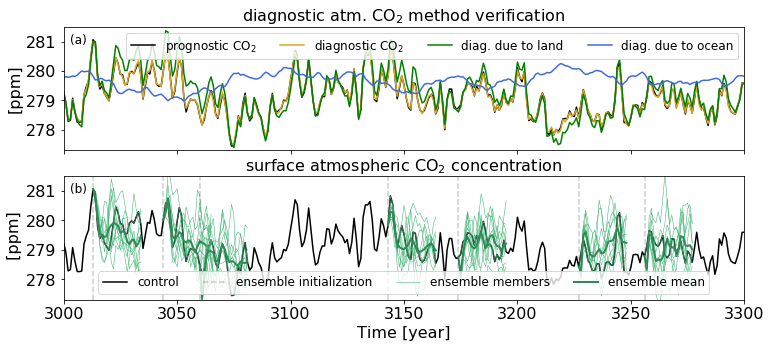

In [7]:
def plot_timeseries(ds,
                    control,
                    ignore=True,
                    ax=False,
                    ens_color='mediumseagreen',
                    ensmean_color='seagreen',
                    mean_line=False):
    """Plot an ensemble timeseries. Ignore a list of ensembles.

    Args
        ds, control : xr.Dataset
        varname : str
    """
    ignore_ens = [3023, 3124, 3139, 3178, 3237]
    if not ax:
        fig, ax = plt.subplots(figsize=(20, 5))

    # plot control
    control = control.to_series()
    ax.plot(control, color='black', alpha=1, label='control')
    if mean_line:
        ax.axhline(control.mean(), color='blue', alpha=.1)

    # plot ens, ensmean, vertical lines
    for ens in ds.ensemble.values:
        if ignore and ens in ignore_ens:
            continue
        ax.axvline(
            x=ens - 1,
            color='black',
            alpha=.2,
            linestyle='--',
            label='ensemble initialization')
        df = ds.sel(
            ensemble=ens).to_dataframe('varname').unstack()['varname'].T
        df[0] = control.loc[ens - 1]
        df = df.T.sort_index(axis=0)
        df.index = np.arange(ens - 1, ens - 1 + df.index.size)
        ax.plot(df, color=ens_color, linewidth=0.5, label='ensemble members')
        ax.plot(
            df.mean(axis=1),
            color=ensmean_color,
            linewidth=2,
            alpha=1,
            label='ensemble mean')

    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol=4,
              prop={'size': 12}, loc='lower center')


# Fig. 1ab
fig, ax2 = plt.subplots(nrows=2,
                        ncols=1, figsize=(11, 5), sharex=True)
i = 0
# set prog to diag level, use free parameter
prog = control_global['CO2']
diag = control_global['diag_CO2']
diff = -prog.mean('time')+diag.mean('time')
prog = prog+diff
prog.plot(c='black', label='prognostic CO$_2$', ax=ax2[i])
diag.plot(c='goldenrod', label='diagnostic CO$_2$', ax=ax2[i])
control_global['diag_CO2_land'].plot(
    c='green', label='diag. due to land', ax=ax2[i])
control_global['diag_CO2_ocean'].plot(
    c='royalblue', label='diag. due to ocean', ax=ax2[i])
ax2[i].set_title('diagnostic atm. CO$_2$ method verification')
ax2[i].set_ylabel('[ppm]')
ax2[i].legend(ncol=4, fontsize=12)
ax2[i].set_yticks([278, 279, 280, 281])
ax2[i].set_ylim([277.3, 281.5])
ax2[i].set_xlabel('')
ax2[i].add_artist(AnchoredText('(' + labels[i] + ')', prop=dict(
    size=12), frameon=False, loc=2, pad=.05))
v = 'CO2'
i = 1
plot_timeseries(ds_global[v]+diff.values, prog, ax=ax2[i])
# ax[i].set_title(v)
ax2[i].set_xlim([3000, 3300])
ax2[i].set_ylabel(' [' + units[v] + ']')
ax2[i].set_title(longname[v])
ax2[i].set_yticks([278, 279, 280, 281])
ax2[i].set_ylim([277.3, 281.5])
ax2[i].add_artist(AnchoredText('(' + labels[i] + ')', prop=dict(
    size=12), frameon=False, loc=2, pad=.05))
ax2[i].set_xlabel('Time [year]')
plt.tight_layout(h_pad=.1)
plt.subplots_adjust(top=0.92)
if savefig:
    plt.savefig(path_paper + 'Figure1_global_timeline_overview')

### Figure 1cd

In [11]:
def vwmp_bootstrap(control, l=100, bootstrap=10, sig=99):
    """Bootstrap variance weighted mean period from control. Masked areas are non-significant. Rejected at 1-sig% level."""
    from climpred.bootstrap import varweighted_mean_period_threshold
    d = []
    for _ in range(int(bootstrap / 5)):
        r = np.random.randint(0, control.time.size - l)
        d.append(varweighted_mean_period(control.isel(time=slice(r, r + l))))
    data = xr.concat(d, 'bootstrap')
    data['lon'] = control.lon
    data['lat'] = control.lat
    vwmp = data.mean('bootstrap')
    threshold = varweighted_mean_period_threshold(
        control, sig=sig, bootstrap=bootstrap)
    threshold['lon'] = control.lon
    threshold['lat'] = control.lat
    vwmp = vwmp.where(vwmp > threshold)
    vwmp.name = 'Period [years]'
    return vwmp

In [14]:
bootstrap = 500
v = 'co2_flux'
control = xr.open_dataset(_get_path(v, prefix='control'))[v]
vwmp_co2_flux = vwmp_bootstrap(control, bootstrap=bootstrap)

v = 'CO2'
control = xr.open_dataset(_get_path(v, prefix='control'))[v].drop('lev')
vwmp_CO2 = vwmp_bootstrap(control, bootstrap=bootstrap)

vwmp = xr.concat([vwmp_co2_flux, vwmp_CO2], 'variable')

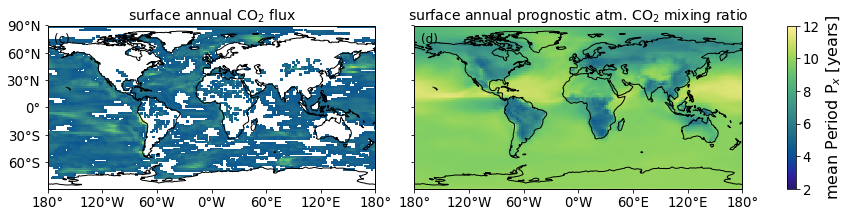

In [15]:
params = {'xtick.labelsize': 'small',
          'ytick.labelsize': 'small',
          }
mpl.rcParams.update(params)
l = ['surface annual CO$_2$ flux',
     'surface annual prognostic atm. CO$_2$ mixing ratio']


g = my_facetgrid(vwmp, col='variable', robust=True, cmap='cmo.haline', aspect=2, cbar_kwargs={
                 'label': 'mean Period P$_x$ [years]'}, vmin=2, vmax=12, plot_lon_lat_axis=True)
for i, ax in enumerate(g.axes.flat):
    ax.set_title(l[i], fontsize=14)
    ax.add_artist(AnchoredText('(' + labels[i+2] + ')', prop=dict(
        size=12), frameon=False, loc=2, pad=.05))
if savefig:
    plt.savefig(path_paper + 'Figure1_vwmp')

## Supplementary Figures

### Fig S2a Mauna Loa 

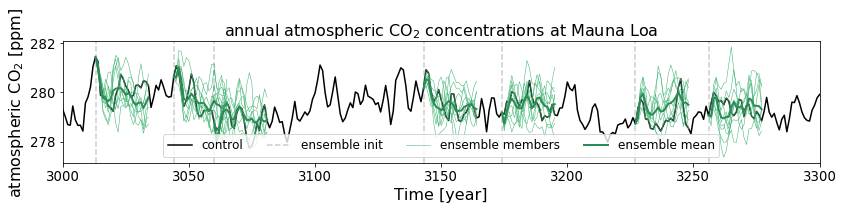

In [183]:
ds_ML = xr.open_dataset(post_ML + 'ds_CO2_ym.nc')
control_ML = xr.open_dataset(post_ML + 'control_CO2_ym.nc')
fig, ax = plt.subplots(figsize=(12, 3))
plot_timeseries(ds_ML['CO2'], control_ML['CO2'], ax=ax)
plt.title('annual atmospheric CO$_2$ concentrations at Mauna Loa')
plt.ylabel('atmospheric CO$_2$ [ppm]')
plt.xlabel('Time [year]')
plt.xlim([3000, 3300])
plt.tight_layout()
if savefig:
    plt.savefig(path_paper + 'Figure1_atmco2_timeline_Mauna_Loa')

## Figure 2

In [22]:
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'smaller'
labelsize = 14

In [19]:
comparison = 'm2e'
sig = 95
psig = (100 - sig) / 100
bootstrap = 5000

control = xr.open_dataset(post_global + 'control_diagnosed_co2.nc')
ds = xr.open_dataset(post_global + 'ds_diagnosed_co2.nc')

# rename dims to climpred requirements
if 'ensemble' in ds.dims:
    ds = ds.rename({'ensemble': 'init', 'time': 'lead'})

In [20]:
p = '../data/results/'
compute = False
if compute:
    bs_acc = bootstrap_perfect_model(
        ds, control, metric='pearson_r', comparison=comparison, bootstrap=bootstrap, sig=sig)
    if save_nc:
        bs_acc.to_netcdf(p+'_'.join(['results', 'global', 'ym', 'metric', 'pearson_r',
                                     'comparison', comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc')
    bs_rmse = bootstrap_perfect_model(
        ds, control, metric='rmse', comparison=comparison, bootstrap=bootstrap, sig=sig)
    if save_nc:
        bs_rmse.to_netcdf(p+'_'.join(['results', 'global', 'ym', 'metric', 'rmse',
                                      'comparison', comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc')
else:
    bs_acc = xr.open_dataset(p+'_'.join(['results', 'global', 'ym', 'metric', 'pearson_r',
                                         'comparison', comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc')
    bs_rmse = xr.open_dataset(p+'_'.join(['results', 'global', 'ym', 'metric', 'rmse',
                                          'comparison', comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc')

In [23]:
def plot_both_skill(bs_acc, bs_rmse, ax=None, unit='unit', not_all=True, sig=95, plot_lead_ints=True):
    """Plot RMSE and ACC skill on x and y axis."""
    fontsize = 8
    c_uninit = 'indianred'
    c_init = 'steelblue'
    c_pers = 'gray'
    capsize = 4
    p = (100 - sig) / 100  # 0.05
    ci_low = p / 2  # 0.025
    ci_high = 1 - p / 2  # .975
    pers_sig = sig

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))

    # acc
    init_skill = bs_acc.sel(kind='init', results='skill')
    init_ci = bs_acc.sel(kind='init', results=['low_ci', 'high_ci']).rename(
        {'results': 'quantile'}
    )
    uninit_skill = bs_acc.sel(kind='uninit', results='skill').isel(lead=0)
    uninit_ci = (
        bs_acc.sel(kind='uninit', results=['low_ci', 'high_ci'])
        .rename({'results': 'quantile'})
        .isel(lead=0)
    )
    pers_skill = bs_acc.sel(kind='pers', results='skill')
    pers_ci = bs_acc.sel(kind='pers', results=['low_ci', 'high_ci']).rename(
        {'results': 'quantile'}
    )
    p_uninit_over_init = bs_acc.sel(kind='uninit', results='p')
    p_pers_over_init = bs_acc.sel(kind='pers', results='p')

    # rmse
    init_skill2 = bs_rmse.sel(kind='init', results='skill')
    init_ci2 = bs_rmse.sel(kind='init', results=['low_ci', 'high_ci']).rename(
        {'results': 'quantile'}
    )
    uninit_skill2 = bs_rmse.sel(kind='uninit', results='skill').isel(lead=0)
    uninit_ci2 = (
        bs_rmse.sel(kind='uninit', results=['low_ci', 'high_ci'])
        .rename({'results': 'quantile'})
        .isel(lead=0)
    )
    pers_skill2 = bs_rmse.sel(kind='pers', results='skill')
    pers_ci2 = bs_rmse.sel(kind='pers', results=['low_ci', 'high_ci']).rename(
        {'results': 'quantile'}
    )
    p_uninit_over_init2 = bs_rmse.sel(kind='uninit', results='p')
    p_pers_over_init2 = bs_rmse.sel(kind='pers', results='p')

    # PH
    beat_uninit = init_skill.where(p_uninit_over_init < psig)
    beat_uninit2 = init_skill2.where(p_uninit_over_init2 < psig)
    ph1 = int(init_skill.where(p_uninit_over_init <
                               psig).notnull().argmin().values)
    if ph1 is 0 and beat_uninit.all():
        ph1 = beat_uninit.lead.size
    ph2 = int(init_skill2.where(p_uninit_over_init2 <
                                psig).notnull().argmin().values)
    if ph2 is 0 and beat_uninit2.all():
        ph2 = beat_uninit2.lead.size
    print('PH:: ACC:', ph1, ', RMSE:', ph2)
    ph = min(ph1, ph2)
    ph_max = max(ph1, ph2)
    # make non sig less visible
    ax.errorbar(
        init_skill2[ph_max:],
        init_skill[ph_max:],
        yerr=[
            init_skill[ph_max:] - init_ci.isel(quantile=0)[ph_max:],
            init_ci.isel(quantile=1)[ph_max:] - init_skill[ph_max:]
        ],
        xerr=[
            init_skill2[ph_max:] - init_ci2.isel(quantile=0)[ph_max:],
            init_ci2.isel(quantile=1)[ph_max:] - init_skill2[ph_max:]
        ],
        fmt='--o',
        alpha=.2,
        capsize=capsize,
        zorder=1,
        c=c_uninit,
        label='')
    # init
    ax.errorbar(
        init_skill2[:ph_max],
        init_skill[:ph_max],
        yerr=[
            init_skill[:ph_max] - init_ci.isel(quantile=0)[:ph_max],
            init_ci.isel(quantile=1)[:ph_max] - init_skill[:ph_max]
        ],
        xerr=[
            init_skill2[:ph_max] - init_ci2.isel(quantile=0)[:ph_max],
            init_ci2.isel(quantile=1)[:ph_max] - init_skill2[:ph_max]
        ],
        fmt='--o',
        capsize=capsize,
        c=c_uninit,
        label='initialized at ' + str(sig) + '% confidence interval')
    # uninit
    ax.errorbar(
        uninit_skill2,
        uninit_skill,
        xerr=[[uninit_skill2 - uninit_ci2.isel(quantile=0)],
              [uninit_ci2.isel(quantile=1) - uninit_skill2]],
        yerr=[[uninit_skill - uninit_ci.isel(quantile=0)],
              [uninit_ci.isel(quantile=1) - uninit_skill]],
        fmt='--o',
        capsize=capsize,
        c=c_init,
        zorder=4,
        label='uninitialized at ' + str(sig) + '% confidence interval')

    s = 150
    ax.scatter(init_skill2[:ph1], init_skill[:ph1], marker='*',
               c='gray', s=s, alpha=.5, zorder=10, label='')
    ax.scatter(init_skill2[:ph2], init_skill[:ph2], marker='*',
               c='gray', s=s, alpha=.5, zorder=10, label='')
    ax.scatter(init_skill2[:ph], init_skill[:ph], marker='*',
               c='k', s=s, zorder=10, label='significant at ' + str(sig) + '% level')
    # add int labels
    if plot_lead_ints:
        for i in np.arange(ph):
            ax.text(init_skill2[i], init_skill[i], str(i+1),
                    color='white', zorder=12, fontsize=7, weight='bold', horizontalalignment='center', verticalalignment='center')
    # format
    ax.axvline(x=uninit_skill2, c='steelblue', ls=':')
    ax.axhline(y=uninit_skill, c='steelblue', ls=':')
    if not_all:
        ax.legend(frameon=False, handletextpad=0.05)
        ax.set_ylabel('ACC')
        ax.set_ylim(top=1.)
        ax.set_xlabel('RMSE [' + unit + ']')


vlist = ['co2_flx_ocean', 'co2_flx_land', 'CO2',
         'diag_CO2_ocean', 'diag_CO2_land', 'diag_CO2']


def plot_fig2(bs_acc, bs_rmse, label_offset=0, sig=95):
    """Plot RMSE and ACC skill for 6 variables. Spring and Ilyina, 2019 Figure 2."""
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(
        15, 6), sharey='row', sharex=False)
    for i, ax in enumerate(axes.flatten()[:6]):
        v = vlist[i]
        plot_both_skill(bs_acc[v], bs_rmse[v],
                        ax=ax, unit=units[v], not_all=False, sig=sig)
        ax.set_title(shortname[v])
        ax.set_xlabel('RMSE [' + units[v] + ']')
        ax.add_artist(AnchoredText('(' +
                                   labels[i + label_offset] + ')', prop=dict(size=labelsize), frameon=False, loc=2, pad=.05, borderpad=.1))
    axes[0, 0].set_ylabel('ACC [ ]')
    axes[1, 0].set_ylabel('ACC [ ]')
    axes[0, 2].set_xlim([0, .9])
    axes[1, 2].set_xlim([0, .9])
    axes[0, 0].set_ylim([-.6, 1.1])
    axes[1, 0].set_ylim([-.6, 1.1])
    axes[1, 0].legend(fontsize=10, frameon=False)
    plt.tight_layout(h_pad=.1)

PH:: ACC: 4 , RMSE: 2
PH:: ACC: 3 , RMSE: 2
PH:: ACC: 3 , RMSE: 3
PH:: ACC: 21 , RMSE: 12
PH:: ACC: 12 , RMSE: 5
PH:: ACC: 8 , RMSE: 4


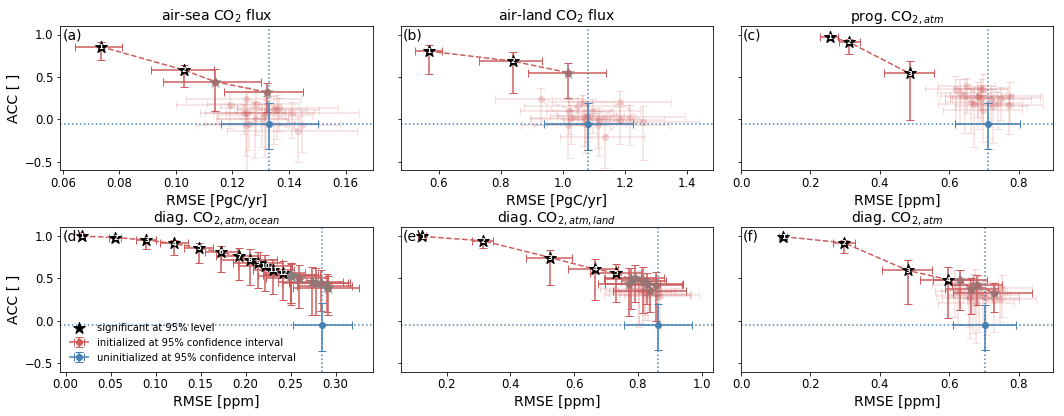

In [23]:
# plot and save
plot_fig2(bs_acc, bs_rmse)
savefig = True
if savefig:
    plt.savefig(path_paper + 'Figure2_2_co2_flux_skill', bbox_inches='tight')

## Figure 3 and 4

In [176]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'

In [24]:
bootstrap=1000
tmp='../data/tmp/'
#save_nc=True

In [ ]:
# computation
for metric in ['pearson_r', 'rmse']:
    for v in ['co2_flux_cumsum', 'co2_flux', 'CO2']:
        varstring = copy(v)
        if v.endswith('_cumsum'):
            v = v[:-7]
        print(v, varstring)
        ds = xr.open_dataset(data_path + 'ds_' + v + '_ym.nc')
        control = xr.open_dataset(data_path + 'control_' + v + '_ym.nc')
        ds, control = comply_climpred(ds, control)
        if varstring is 'co2_flux_cumsum':
            print('cumsum')
            # remove mean and aggregate
            a = (ds - control.mean('time')).cumsum('lead')
            b = (control - control.mean('time')).cumsum('time')
            a['lead'] = ds.lead
            b['time'] = control.time
            ds = a
            control = b
        else:  # faster
            ds = ds.isel(lead=slice(None, 10))

        bs = bootstrap_perfect_model(
            ds, control, metric=metric, comparison=comparison, bootstrap=bootstrap, sig=sig)
        if save_nc:
            bs.to_netcdf(tmp+'_'.join(['results', varstring, 'ym', 'metric', metric, 'comparison',
                                   comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc')

In [ ]:
#### plot prototyping

sig = 99
bootstrap = 1000
comparison = 'm2e'
psig = .05

# prototyping
metric = 'rmse'
v = 'co2_flux'
varstring = copy(v)
if varstring.endswith('cumsum'):
    v = v[:-7]
fname = '_'.join(['results', varstring, 'ym', 'metric', metric, 'comparison',
                  comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc'
ds = xr.open_dataset(fname)[v]
skill = ds.sel(results='skill', kind='init').where(
    ds.sel(results='p', kind='uninit') <= psig)
# skill.plot(col='lead', col_wrap=5)

In [150]:
def ph_from_skill(skill):
    """Get predictability horizon (ph) from skill at last non-nan lead while setting all-nan leads to zero PH. Nans are masked if p below psig."""
    ph = skill.argmin('lead', skipna=False)
    ph = ph.where(ph != 0, np.nan)
    ph_not_reached = (skill.notnull()).all('lead')
    ph = ph.where(~ph_not_reached, other=skill['lead'].max())
    return ph

ph = ph_from_skill(skill)
# ph.plot()

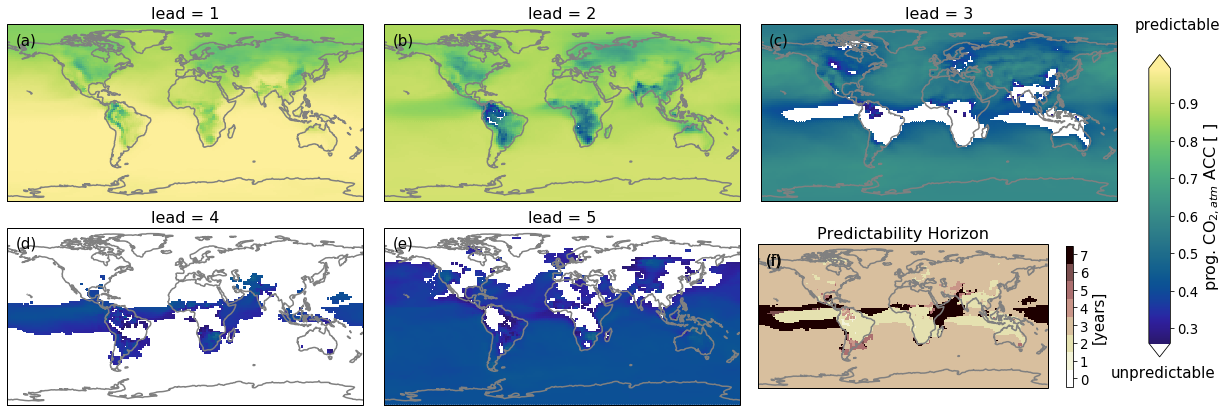

In [199]:
def plot_ph(ph, vmax=12, vmin=0, cmapstr='viridis', ax=None, curv=False, plot_cb_phname=True, cbar_shrink=1):
    """Plot predictability horizon with stride 1 colormap."""
    ph.name = 'Predictability Horizon [years]'
    ph_levels = [_ for _ in range(vmin, vmax + 1)]
    ncolors = len(ph_levels)
    cmap = _cmap_discretize(cmapstr, ncolors)
    #cmap.set_under('white')
    mappable = ScalarMappable(cmap=cmap)
    mappable.set_array([])
    l_min = max(vmin, np.min(ph_levels))
    l_max = min(np.max(ph_levels), vmax)
    ticks = np.arange(l_min, l_max + 1)
    mappable.set_clim(l_min - 0.5, l_max + 0.5)
    if ax is None:
        p = my_plot(ph.where(ph > 0), levels=ph_levels,
                    add_colorbar=False, cmap=cmapstr, curv=curv)
    else:
        p = my_plot(ph.where(ph > 0), levels=ph_levels,
                    add_colorbar=False, ax=ax, cmap=cmapstr, curv=curv)
    cb = plt.colorbar(mappable, ax=ax, shrink=cbar_shrink)
    if vmax==20:
        ticks=[0,5,10,15,20]
    cb.set_ticks(ticks)
    cb.set_ticklabels(ticks)
    cb.ax.set_ylabel('[years]', fontsize=15)
    return p


def plot_fig_lead_ph(skill2, ph, metric, cmap='viridis_r', max_ph=7, varstring=None, robust_level=None, **kwargs):
    """Plot first five leads and predictability horizon as panel plot.

    See Spring and Ilyina, 2019 Figs. 3 & 4."""
    if varstring is None:
        varstring = skill2.name
    projection = ccrs.PlateCarree()
    # faking robust for show contours for land and ocean co2_flux
    # which are at different levels of magnitude
    if robust_level is None:
        if v is 'co2_flux' and metric is 'rmse':
            robust_level_lower = 0.000001
            robust_level_upper = .925
            print('set robust', robust_level_lower, robust_level_upper)
        else:
            robust_level_lower = 0.01
            robust_level_upper = 1 - robust_level_lower
    vmin = skill2.quantile(robust_level_lower).values
    vmax = skill2.quantile(robust_level_upper).values

    if ph.quantile(.98) > 15:
        max_ph=20
    fig, ax = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(
        20, 7), subplot_kw={'projection': projection})
    for i, axes in enumerate(ax.flatten()):
        if i == 5:
            pass
        else:
            p = my_plot(skill2.isel(
                lead=i), ax=axes, add_colorbar=False, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
        axes.add_artist(AnchoredText('(' + labels[i] + ')', prop=dict(
            size=15), frameon=False, loc=2, pad=.05))
    c = .93
    c_map_ax = fig.add_axes([c - .01, 0.22, 0.015, 0.6])

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap2 = copy(plt.get_cmap(cmap))
    # set unpredictable, masked part of colorbar to white
    if metric is 'pearson_r':
        cmap2.set_under('white', 1.)
    elif metric is 'rmse':
        cmap2.set_over('white', 1.)
    sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
    sm.set_array([])
    metricname = metric_dict[metric]
    unit = units[varstring]
    if metric is 'pearson_r':
        unit = ' '
    cb = fig.colorbar(sm, cax=c_map_ax, orientation='vertical', extend='both',
                      label=' '.join([shortname[varstring], metricname, '[' + unit + ']']))
    del cmap2
    del sm
    # annotations
    pred_helper_labels = ['unpredictable', 'predictable']
    if metric is 'pearson_r':
        pred_helper_labels = pred_helper_labels[::-1]
    fig.text(c + 0.01, .87, pred_helper_labels[0],
             fontsize=15, horizontalalignment='center')  # top
    fig.text(c, .18, pred_helper_labels[1], fontsize=15,
             horizontalalignment='center')  # bottom

    # plot ph
    axph = ax[1, 2]
    if not cmap.endswith('_r') and isinstance(cmap, str):
        cmap = cmap + '_r'
    assert isinstance(cmap, str)
    plot_ph(ph, ax=axph, plot_cb_phname=False,
            cbar_shrink=.8, vmax=max_ph, cmapstr='pink_r')
    if v == 'CO2':  # plot CO2 station location only when CO2 is varname
        _plot_co2_stations(ph=ph, print_results=True,
                           print_station_names=False, ax=axph)
    axph.set_title('Predictability Horizon')
    # set abc
    axph.add_artist(AnchoredText('(' + labels[-1] + ')', prop=dict(
        size=15), frameon=False, loc=2, pad=.05))

    plt.subplots_adjust(wspace=0.04, hspace=0.15)
    del cmap

plot_fig_lead_ph(skill, ph, metric, cmap='cmo.haline', levels=None, varstring=varstring)

co2_flux co2_flux pearson_r ACC cmo.haline_r


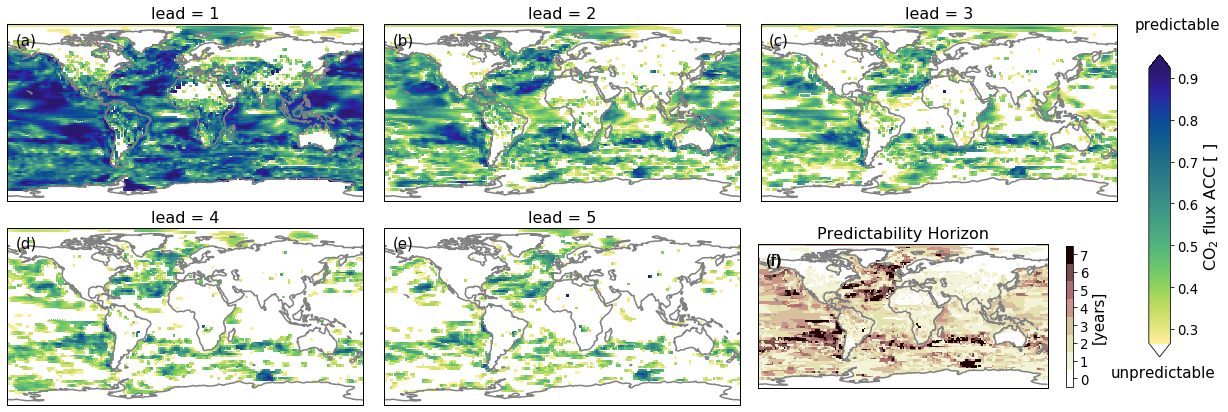

CO2 CO2 pearson_r ACC cmo.haline_r
Predictability Horizon for different stations
                    lat     lon  predictability horizon
Alert             82.28  -62.30                     3.0
Point Barrow      71.19 -156.36                     3.0
La Jolla          32.90 -117.30                     3.0
Mauna Loa         19.32 -155.35                     3.0
Christmas Island   2.00 -157.17                     6.0
American Samoa   -14.15 -170.34                     3.0
Kermadec Islands -29.20 -177.90                     3.0
Baring Head      -41.24  174.54                     3.0
South Pole       -89.59  -24.48                     3.0


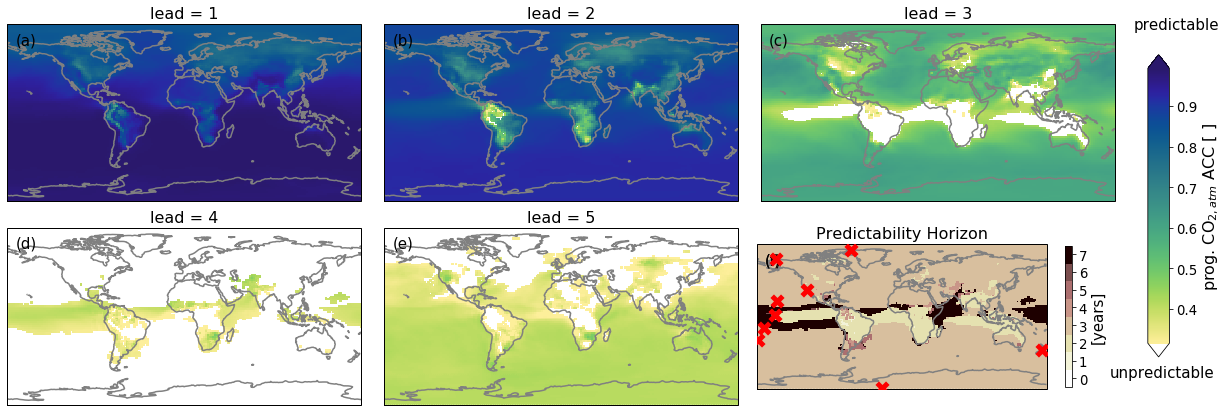

co2_flux co2_flux_cumsum pearson_r ACC cmo.haline_r


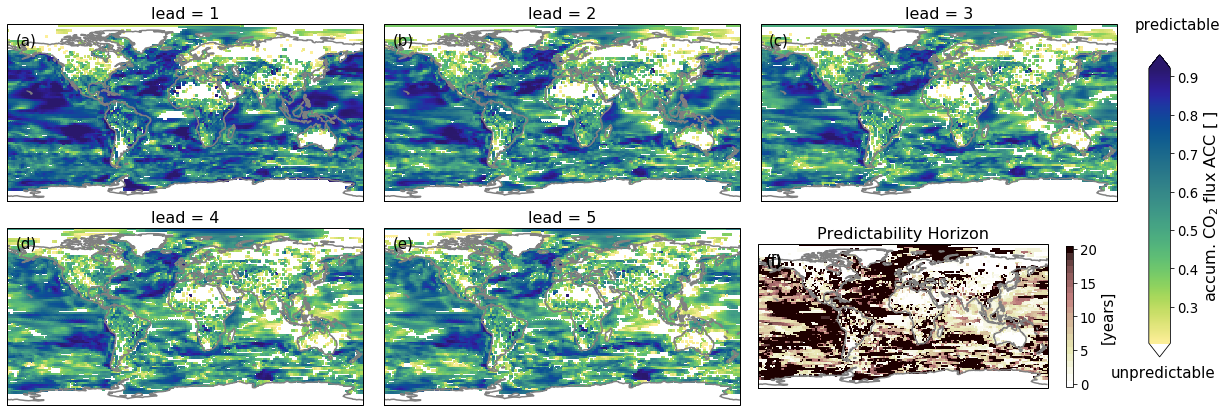

conv
co2_flux co2_flux rmse RMSE cmo.haline
set robust 1e-06 0.925


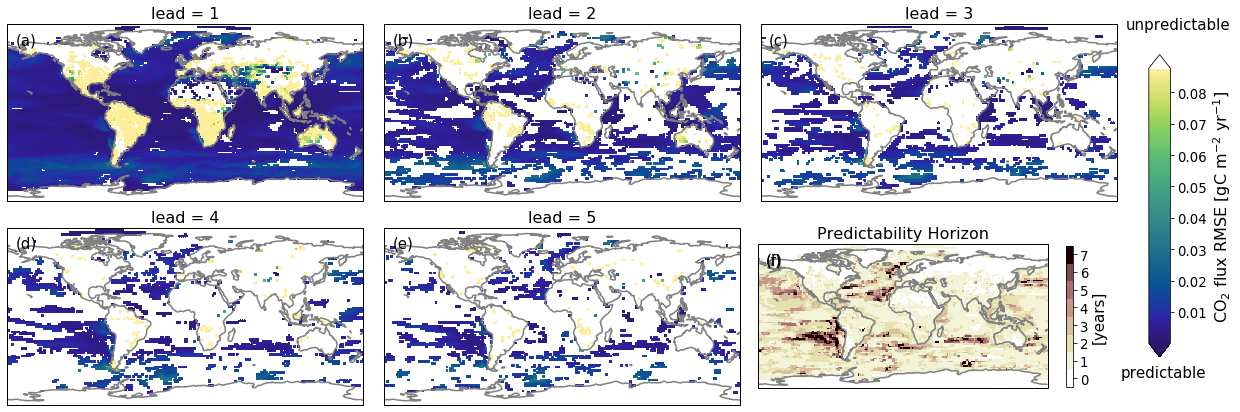

CO2 CO2 rmse RMSE cmo.haline
Predictability Horizon for different stations
                    lat     lon  predictability horizon
Alert             82.28  -62.30                     0.0
Point Barrow      71.19 -156.36                     0.0
La Jolla          32.90 -117.30                     4.0
Mauna Loa         19.32 -155.35                     4.0
Christmas Island   2.00 -157.17                     3.0
American Samoa   -14.15 -170.34                     3.0
Kermadec Islands -29.20 -177.90                     3.0
Baring Head      -41.24  174.54                     3.0
South Pole       -89.59  -24.48                     3.0


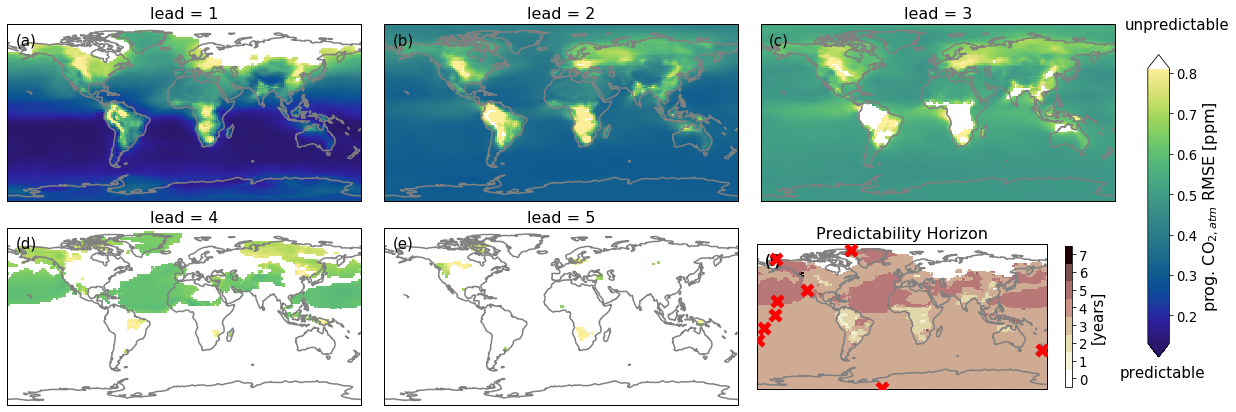

conv
co2_flux co2_flux_cumsum rmse RMSE cmo.haline


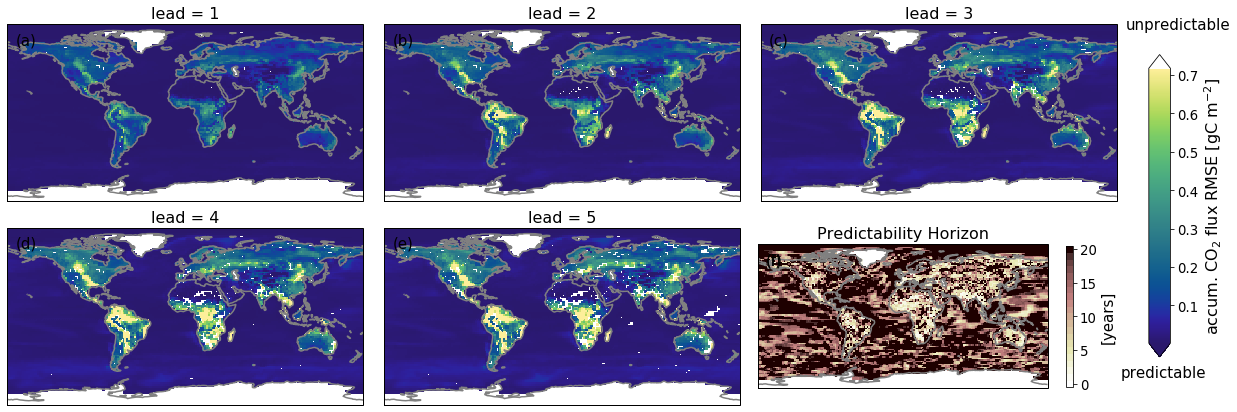

In [186]:
# Plotting loop
conv = 24 * 3600 * 365
psig = .05
max_ph = 7
for metric in ['pearson_r', 'rmse']:
    for v in ['co2_flux', 'CO2', 'co2_flux_cumsum']:
        cmap = 'cmo.haline_r'
        varstring = copy(v)
        if varstring.endswith('cumsum'):
            v = v[:-7]
        fname = tmp+'_'.join(['results', varstring, 'ym', 'metric', metric, 'comparison',
                          comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc'
        ds = xr.open_dataset(fname)[v]
        skill = ds.sel(results='skill', kind='init').where(
            ds.sel(results='p', kind='uninit') <= psig)

        if metric == 'rmse' and v == 'co2_flux':
            skill = skill * conv
            print('conv')

        ph = ph_from_skill(skill)
        skill2 = skill.isel(lead=slice(None, 5))
        if metric == 'rmse' and isinstance(cmap, str):
            if not cmap.endswith('_r'):
                cmap = cmap + '_r'
            else:
                if isinstance(cmap, str):
                    cmap = cmap[:-2]
        metricname = metric_dict[metric]
        print(v, varstring, metric, metricname, cmap)
        plot_fig_lead_ph(skill2, ph, metric, cmap,
                         max_ph=max_ph, varstring=varstring)
        if savefig:
            plt.savefig(path_paper + 'Figure3_' + varstring +
                        '_' + metricname, bbox_inches='tight')
        plt.show()

##### Note filenames contain sig and bootstrap information. However, the siglevel there is only important for low_ci and high_ci, but for my calculatation I use only skill and mask p where lower than psig.

### extract Predictability Horizon table for latex

In [25]:
def ph_from_skill(skill):
    ph = skill.argmin('lead', skipna=False)
    ph = ph.where(ph != 0, np.nan)
    ph_not_reached = (skill.notnull()).all('lead')
    ph = ph.where(~ph_not_reached, other=skill['lead'].max())
    return ph

In [26]:
metric = 'rmse'
v = 'CO2'
sig = 99
bootstrap = 1000
comparison = 'm2e'
varstring = copy(v)

fname = tmp+'_'.join(['results', varstring, 'ym', 'metric', metric, 'comparison',
                  comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc'
psig = .05
ds = xr.open_dataset(fname)[v]
skill = ds.sel(results='skill', kind='init').where(
    ds.sel(results='p', kind='uninit') <= psig)

Predictability Horizon for different stations
                    lat     lon  predictability horizon
Alert             82.28  -62.30                     0.0
Point Barrow      71.19 -156.36                     0.0
La Jolla          32.90 -117.30                     4.0
Mauna Loa         19.32 -155.35                     4.0
Christmas Island   2.00 -157.17                     3.0
American Samoa   -14.15 -170.34                     3.0
Kermadec Islands -29.20 -177.90                     3.0
Baring Head      -41.24  174.54                     3.0
South Pole       -89.59  -24.48                     3.0


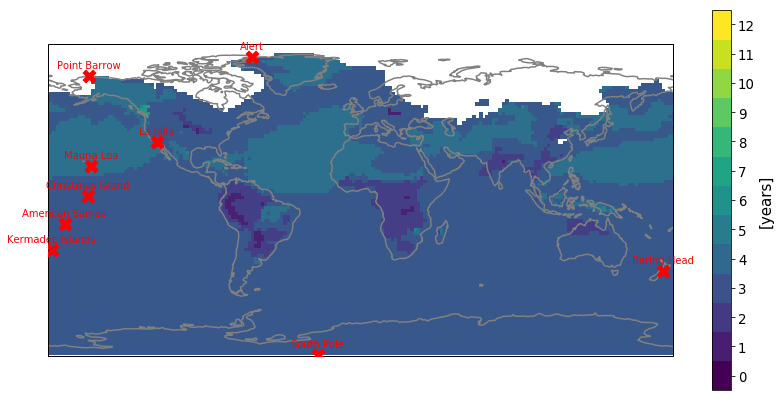

In [188]:
# extract Predictability Horizon table
ph = ph_from_skill(skill)
#plot_ph(ph)

df_ph_rmse = _plot_co2_stations(ph)

In [27]:
metric = 'pearson_r'
fname = tmp+'_'.join(['results', varstring, 'ym', 'metric', metric, 'comparison',
                  comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc'
psig = .05
ds = xr.open_dataset(fname)[v]

skill = ds.sel(results='skill', kind='init').where(
    ds.sel(results='p', kind='uninit') <= psig)

Predictability Horizon for different stations
                    lat     lon  predictability horizon
Alert             82.28  -62.30                     3.0
Point Barrow      71.19 -156.36                     3.0
La Jolla          32.90 -117.30                     3.0
Mauna Loa         19.32 -155.35                     3.0
Christmas Island   2.00 -157.17                     6.0
American Samoa   -14.15 -170.34                     3.0
Kermadec Islands -29.20 -177.90                     3.0
Baring Head      -41.24  174.54                     3.0
South Pole       -89.59  -24.48                     3.0


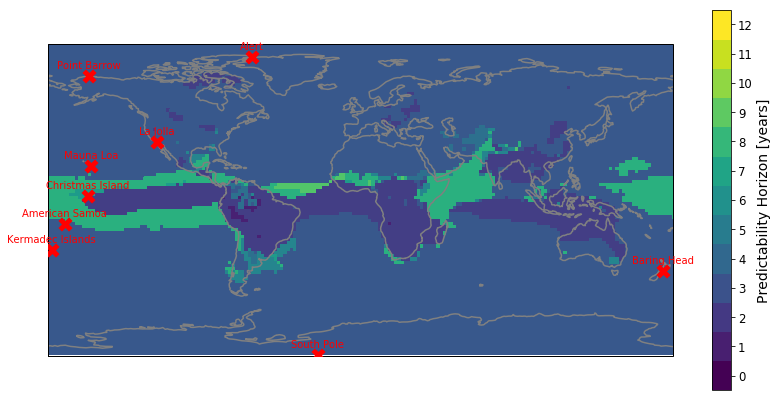

In [28]:
ph = ph_from_skill(skill)
plot_ph(ph)
df_ph_acc = _plot_co2_stations(ph)

In [64]:
df_ph = pd.merge(df_ph_rmse, df_ph_acc, how='outer').T

df_ph.columns = ['Lon', 'Lat', 'PH RMSE', 'PH ACC']

df_ph = df_ph.astype('int')

if save_nc:
    with open('ph_co2_stations.txt', 'w') as tf:
        tf.write(df_ph.to_latex())

# Supplementary information

## composite_analysis

In [30]:
# Load ENSO
control3d = xr.open_dataset(_get_path(
    'tos', prefix='control'))
control3d = control3d - \
    control3d.rolling(time=10, center=True, min_periods=1).mean()
import PMMPIESM as PM
nino34_mask = xr.open_dataset(
    PM.setup.file_origin + 'masks/enso_34_mask.nc')['alon'].squeeze()
# nino34_mask.plot()

enso = (control3d * nino34_mask).mean(['x', 'y']).squeeze()['tos']
# enso.plot()
del enso['depth']

threshold = 1

In [192]:
def quiver(background_map, u, v, proj=ccrs.PlateCarree(), ax=None, quiverreference_size=1, coastline_color='gray', qkx=0.85, qky=.95, **kwargs):
    """Plot arrows over background map."""
    if ax is None:
        ax = plt.axes(projection=proj)
    if background_map is None:
        ax.stock_img()
    else:
        background_map.plot.pcolormesh(
            'lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), **kwargs)
    lon = u.lon.values
    lat = u.lat.values
    Q = ax.quiver(lon, lat, u.values, v.values, transform=ccrs.PlateCarree(
        central_longitude=-180), width=0.002, regrid_shape=25, color='black')
    ax.coastlines(color=coastline_color, linewidth=1.5)
    qk = plt.quiverkey(Q, qkx, qky, quiverreference_size, str(quiverreference_size) + r'$\frac{m}{s}$', labelpos='E',
                       coordinates='figure')

In [193]:
# quiver plot
v = 'u10'
u10 = xr.open_dataset(_get_path(
    v, prefix='control'))[v].squeeze()
ano = (u10 - u10.mean('time'))
comp_u10 = composite_analysis(
    ano, enso, plot=False, ttest=True, robust=True, yincrease=True, cmap='coolwarm', threshold=threshold)

v = 'v10'
v10 = xr.open_dataset(_get_path(
    v, prefix='control'))[v].squeeze()
ano = (v10 - v10.mean('time'))
comp_v10 = composite_analysis(
    ano, enso, plot=False, ttest=True, robust=True, yincrease=True, cmap='coolwarm', threshold=threshold)

v = 'CO2'
CO2 = xr.open_dataset(_get_path(
    v, prefix='control'))[v].squeeze()
del CO2['lev']
CO2.name = 'CO$_2$ [ppm]'
ano = (CO2 - CO2.mean('time'))
comp_CO2 = composite_analysis(
    ano, enso, plot=False, robust=True, ttest=True, yincrease=True, cmap='coolwarm', threshold=threshold)

v = 'co2_flux'
co2_flux = xr.open_dataset(_get_path(
    v, prefix='control'))[v].squeeze()
ano = (co2_flux - co2_flux.mean('time'))
comp_co2_flux = composite_analysis(
    ano, enso, plot=False, robust=True, ttest=True, yincrease=True, cmap='coolwarm', threshold=threshold)

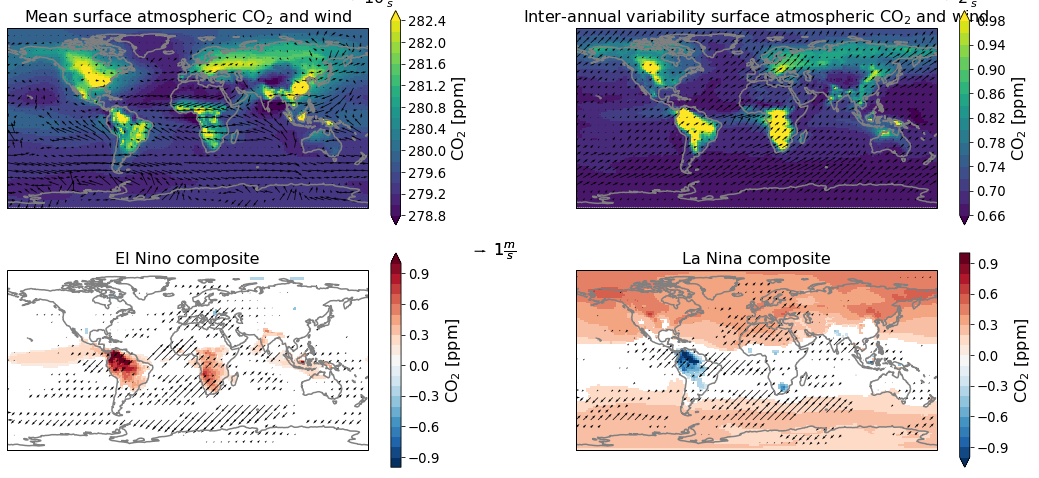

In [203]:
levels = 21
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={
                         'projection': ccrs.PlateCarree()}, figsize=(15, 7))
quiver(CO2.mean('time'), u10.mean('time'), v10.mean('time'),
       quiverreference_size=10, levels=levels, robust=True, cmap='viridis', ax=axes[0, 0], qkx=.35, qky=.97)

axes[0, 0].set_title('Mean surface atmospheric CO$_2$ and wind')
quiver(CO2.std('time'), u10.std('time'), v10.std('time'),
       quiverreference_size=2, levels=levels, cmap='viridis', robust=True, ax=axes[0, 1], qkx=.9, qky=.97)
axes[0, 1].set_title(
    'Inter-annual variability surface atmospheric CO$_2$ and wind')
for i, index in enumerate(['positive', 'negative']):
    quiver(comp_CO2.sel(index=index), comp_u10.sel(index=index), comp_u10.sel(
        index=index), ax=axes[1, i], vmin=-1, vmax=1, cmap='RdBu_r', levels=levels, qkx=.47, qky=.47)
axes[1, 0].set_title('El Nino composite')
axes[1, 1].set_title('La Nina composite')
plt.tight_layout()
if savefig:
    plt.savefig(path_paper + 'Figure10_CO2_wind_enso_composites')

co2_flux


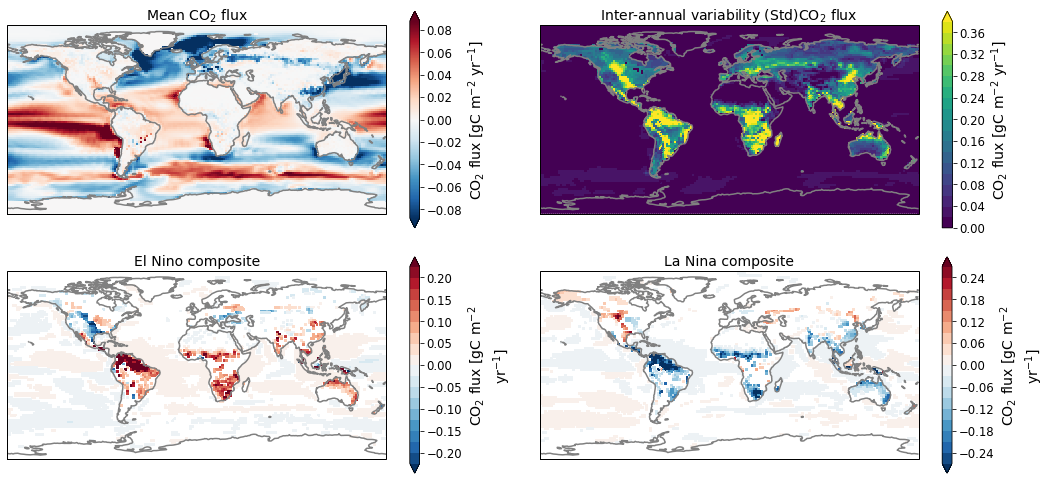

In [31]:
for v in ['co2_flux']:#, 'temp2', 'precip']:
    print(v)
    if v is 'co2_flux_cumsum':
        vdata = xr.open_dataset(_get_path(
            'co2_flux', prefix='control'))['co2_flux'].squeeze()
        vdata = (vdata - vdata.mean('time')).cumsum('time')
        vdata['time'] = np.arange(3000, vdata.time.size + 3000)
    else:
        vdata = xr.open_dataset(_get_path(
            v, prefix='control'))[v].squeeze()

    if 'co2_fl' in v:
        vdata = vdata * 3600 * 24 * 365

    vdata.name = v + ' [' + units[v] + ']'
    ano = (vdata - vdata.mean('time')).compute()

    comp = composite_analysis(
        ano, enso, plot=False, ttest=True, robust=True, yincrease=True, cmap='coolwarm', threshold=threshold)
    comp.name = shortname[v]+' ['+units[v]+']'
    levels = 21
    fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={
                             'projection': ccrs.PlateCarree()}, figsize=(15, 7))
    my_plot(vdata.mean('time'), cmap='RdBu_r',
            ax=axes[0, 0], robust=True, cbar_kwargs={'label': shortname[v]+' ['+units[v]+']'})
    axes[0, 0].set_title('Mean ' + shortname[v])
    my_plot(vdata.std('time'), levels=levels,
            cmap='viridis', robust=True, ax=axes[0, 1], cbar_kwargs={'label': shortname[v]+' ['+units[v]+']'})
    axes[0, 1].set_title('Inter-annual variability (Std)' + shortname[v])
    for i, index in enumerate(['positive', 'negative']):
        my_plot(comp.sel(index=index),
                ax=axes[1, i], robust=True, cmap='RdBu_r', levels=levels)
    axes[1, 0].set_title('El Nino composite')
    axes[1, 1].set_title('La Nina composite')
    plt.tight_layout()
    if savefig:
        plt.savefig(path_paper + 'Figure10_' + v + '_enso_composites')
    plt.show()

## Figure S1: Difference in predictability horizon definitions

In [32]:
def step_lower(x, a):
    return 1 * (x < a)


def step_higher(x, a):
    return 1 * (x >= a)


def func(t, b, ph, c):
    f = step_lower(t, ph) * ((c - b) / (ph) * (t) + b) + step_higher(t, ph) * c
    return f


def fit_ph_int(s, plot=False):
    """
    Calculate quick & dirty predictability horizon (PH) by optimizing squared differences.

    input: pd.series
    output: b, ph, c
    """
    import scipy.optimize as optimization
    t_fit = np.arange(0, s.size)
    sigmav = s.std()
    sigma = np.linspace(sigmav / 2, sigmav, s.size)
    mean = s
    d = []
    e = []
    w = []
    b = s.iloc[0]
    x0 = np.array([0., s[5:].mean()])
    for ph in t_fit:

        def func(t, b, c):
            f = step_lower(t, ph) * ((c - b) / (ph - 1)
                                     * (t - 1) + b) + step_higher(t, ph) * c
            return f

        fit = optimization.curve_fit(func, t_fit, mean, x0, sigma)
        b = fit[0][0]
        c = fit[0][1]
        a = func(t_fit, b, c)
        diff2 = np.sum((mean - a)**2)
        if ph < 15:
            d.append(diff2)
            e.append(b)
            w.append(c)

    def func(t, b, ph, c):
        f = step_lower(t, ph) * ((c - b) / (ph - 1)
                                 * (t - 1) + b) + step_higher(t, ph) * c
        return f

    ph = np.nanargmin(d)
    c = w[ph]
    b = e[ph]
    return b, ph + 1, c

In [33]:
def predictability_horizon(skill):
    """Get predictability horizon (ph) from skill at last non-nan lead while setting all-nan leads to zero PH. Nans are masked if p below psig."""
    ph = skill.argmin('lead', skipna=False)
    ph = ph.where(ph != 0, np.nan)
    ph_not_reached = (skill.notnull()).all('lead')
    ph = ph.where(~ph_not_reached, other=skill['lead'].max())
    return ph

In [34]:
def Sef2018_Fig1_Different_PH_Definitions(ds, control, unit='PgC/yr', sig=95, bootstrap=500):
    # from esmtools.prediction import predictability_horizon
    from PMMPIESM.plot import _set_integer_xaxis
    rsig = (100 - sig)/100
    _control = control
    _ds = ds
    ss = compute_perfect_model(
        _ds, _control, metric='rmse', comparison='m2e')
    ss['lead'] = np.arange(1, ss.lead.size + 1)
    # ss.name = 'every'
    ss_boot = bootstrap_perfect_model(_ds, _control, metric='rmse',
                                      comparison='m2e', sig=sig, bootstrap=bootstrap)
    ss_p = ss_boot.sel(kind='uninit', results='p')
    ss_ci_high = ss_boot.sel(kind='uninit', results='low_ci')

    ph_Spring_2019 = predictability_horizon(
        ss.where(ss_p < rsig)).values

    b_m2e, ph_Sef_2018, c_m2e = fit_ph_int(ss.to_series())
    print('ph_Sef_2018', ph_Sef_2018)
    print('ph_Spring_2019', int(ph_Spring_2019))

    fig, ax = plt.subplots(figsize=(10, 4))
    std = _control.std('time').values

    every_color = 'mediumorchid'
    ss.name = 'skill'
    ss.to_dataframe().plot(ax=ax, label='skill', color='k', marker='o')

    t_fit = np.arange(0, _ds.lead.size)
    ax.plot(t_fit[1:], func(t_fit, b_m2e, ph_Sef_2018, c_m2e)[1:],
            linewidth=3, color=every_color, label='Sef 2018 breakpoint fit')
    ax.axvline(x=ph_Sef_2018, linestyle='-.',
               color=every_color, label='PH Sef 2018')
    ax.axhline(y=std, ls='--', c='k', alpha=.3, label='std control')
    ax.axhline(y=ss_ci_high.mean('lead'), ls=':',
               c='royalblue', label='Bootstrapped high CI')

    ax.axvline(x=ph_Spring_2019, ls='-.', c='royalblue',
               label='PH Spring 2019')
    ax.set_xlabel('Lead Time [time]')
    ax.set_ylabel('RMSE [' + unit + ']')
    ax.set_ylim([0, ss.max() * 1.1])
    ax.set_xlim([0, 10])
    _set_integer_xaxis(ax)
    ax.legend(frameon=False, ncol=2)
    ax.set_xticks(range(1, 11))
    ax.set_title(
        ' Global oceanic CO$_2$ flux: Differences in definitions of Predictability Horizon')
    if savefig:
        plt.tight_layout()
        plt.savefig('Differences_PH_definition')

In [36]:
ds = xr.open_dataset('../data/results/ds_diagnosed_co2.nc')['co2_flx_ocean']
control = xr.open_dataset(
    '../data/results/control_diagnosed_co2.nc')['co2_flx_ocean']
ds, control = comply_climpred(ds, control)

ph_Sef_2018 4
ph_Spring_2019 2


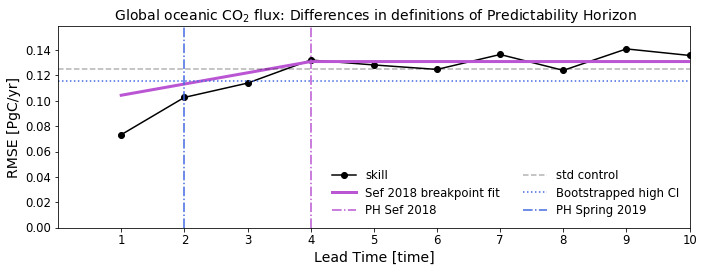

In [37]:
Sef2018_Fig1_Different_PH_Definitions(ds, control)

## Fig S2b: Mauna Loa Predictability

In [41]:
# load data
p = '../data/plain_model_output/Mauna_Loa/'
control = xr.open_dataset(p + 'control_CO2_mm.nc').compute()
ds = xr.open_dataset(p + 'ds_CO2_mm.nc').compute()

ds = yearmonmean(ds)
control = yearmonmean(control)

# rename dims to climpred requirements
if 'ensemble' in ds.dims:
    ds = ds.rename({'ensemble': 'init', 'time': 'lead'})


bootstrap = 5000
compute = False
sig = 95
p = '../data/results/Mauna_Loa/'
if compute:
    bs_acc = bootstrap_perfect_model(
        ds, control, metric='pearson_r', comparison=comparison, bootstrap=bootstrap, sig=sig)
    if save_nc:
        bs_acc.to_netcdf(p+'_'.join(['results', 'MLO', 'ym', 'metric', 'pearson_r',
                                     'comparison', comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc')
    bs_rmse = bootstrap_perfect_model(
        ds, control, metric='rmse', comparison=comparison, bootstrap=bootstrap, sig=sig)
    if save_nc:
        bs_rmse.to_netcdf(p+'_'.join(['results', 'MLO', 'ym', 'metric', 'rmse',
                                      'comparison', comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc')
else:
    bs_acc = xr.open_dataset(p+'_'.join(['results', 'MLO', 'ym', 'metric', 'pearson_r',
                                         'comparison', comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc')
    bs_rmse = xr.open_dataset(p+'_'.join(['results', 'MLO', 'ym', 'metric', 'rmse',
                                          'comparison', comparison, 'sig', str(sig), 'bootstrap', str(bootstrap)]) + '.nc')

PH:: ACC: 3 , RMSE: 4


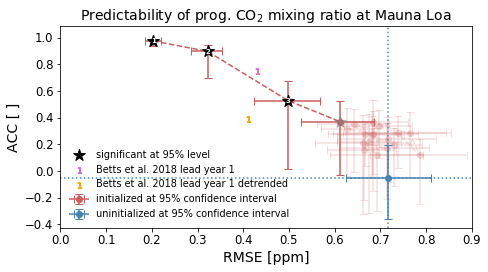

In [42]:
# plot Mauna Loa predictability
# results Betts et al 2016: see scripts/Rebuilding_Betts_2016.ipynb
betts_rmse = .43
betts_acc = .75
betts_rmse_detrended = .41
betts_acc_detrended = .39

v = 'CO2'
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(
    7, 4))
plot_both_skill(bs_acc[v], bs_rmse[v],
                ax=ax, unit=units[v], not_all=False, sig=sig)
ax.set_title(shortname[v])
ax.set_xlabel('RMSE [' + units[v] + ']')
ax.set_ylabel('ACC [ ]')
ax.set_title('Predictability of prog. CO$_2$ mixing ratio at Mauna Loa')
ax.scatter(betts_rmse, betts_acc, marker='$1$',
           label='Betts et al. 2018 lead year 1', color='orchid')
ax.scatter(betts_rmse_detrended, betts_acc_detrended, marker='$1$',
           label='Betts et al. 2018 lead year 1 detrended', color='orange')
ax.legend(loc='lower left', frameon=False, fontsize='x-small')
ax.set_xlim(0, .9)
plt.tight_layout(h_pad=.1)
if savefig:
    plt.savefig(path_paper + 'FigureSI_CO2_skill_MLO', bbox_inches='tight')